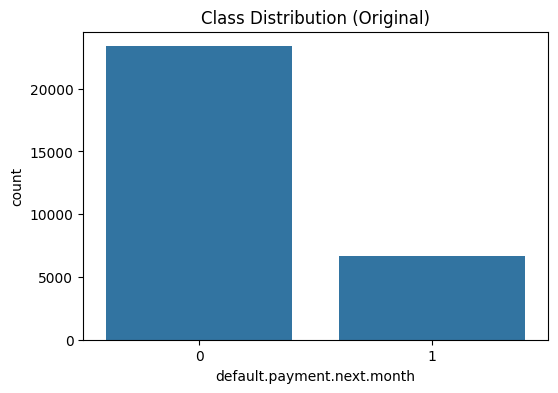

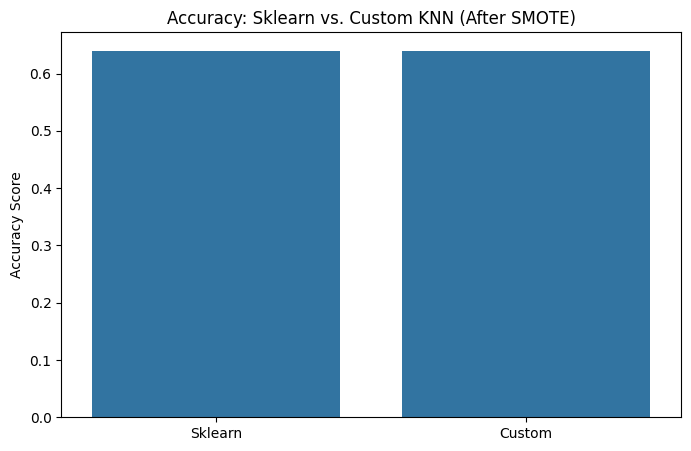

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. LOAD DATA
# Use the full path to avoid the FileNotFoundError
df = pd.read_csv('/UCI_Credit_Card.csv')

# 2. PREPROCESSING
X = df.drop(['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

# Visualize Class Imbalance (Initial Condition)
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Distribution (Original)')
plt.show()

# 3. TRAIN-TEST SPLIT & SCALING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN depends on distance; scaling ensures one feature doesn't dominate others
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. CUSTOM KNN CLASS
class CustomKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.values

    def predict(self, X_test):
        return np.array([self._predict_one(x) for x in X_test])

    def _predict_one(self, x):
        # Euclidean distance calculation
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        # Get labels of K nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Majority vote
        return Counter(k_nearest_labels).most_common(1)[0][0]

# 5. SMOTE FOR BALANCING
# We apply SMOTE to the training data to create a 50/50 split
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# 6. MODEL COMPARISON (Using a subset for speed)
# Custom KNN is slow because it's not optimized like Sklearn
X_eval = X_test_scaled[:100]
y_eval = y_test[:100]

# Sklearn KNN
sk_model = KNeighborsClassifier(n_neighbors=5)
sk_model.fit(X_train_res, y_train_res)
sk_preds = sk_model.predict(X_eval)

# Custom KNN
my_model = CustomKNN(k=5)
my_model.fit(X_train_res, y_train_res)
my_preds = my_model.predict(X_eval)

# 7. VISUAL COMPARISON
labels = ['Sklearn', 'Custom']
acc = [accuracy_score(y_eval, sk_preds), accuracy_score(y_eval, my_preds)]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=acc)
plt.title('Accuracy: Sklearn vs. Custom KNN (After SMOTE)')
plt.ylabel('Accuracy Score')
plt.show()